***1. Cargar Librerías Necesarias***

In [83]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.pyplot as plt


 2. Cargar ***Dataset***

In [84]:
from google.colab import drive
drive.mount('/content/drive')

# Especifica la ruta del archivo en tu Google Drive
ruta = '/content/drive/MyDrive/2do parcial IA/2017_Yellow_Taxi_Trip_Data.csv'  # Modifica esto según tu ubicación

# Leer el archivo CSV desde Google Drive
df = pd.read_csv(ruta)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


***3. Selección de Características (Ejemplo con las dos primeras columnas numéricas)***

In [85]:
X = df.select_dtypes(include=[np.number]).iloc[:, :2].dropna().values  # Selección y limpieza


***4. Visualización Inicial de los Datos (sin clasificar antes de usar Kmeans)***

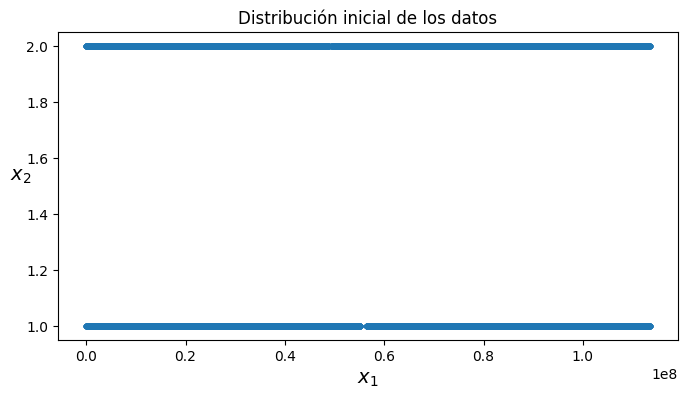

In [86]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.title("Distribución inicial de los datos")
plt.show()

***5. Determinar Número Óptimo de Clusters (Método del Codo)***

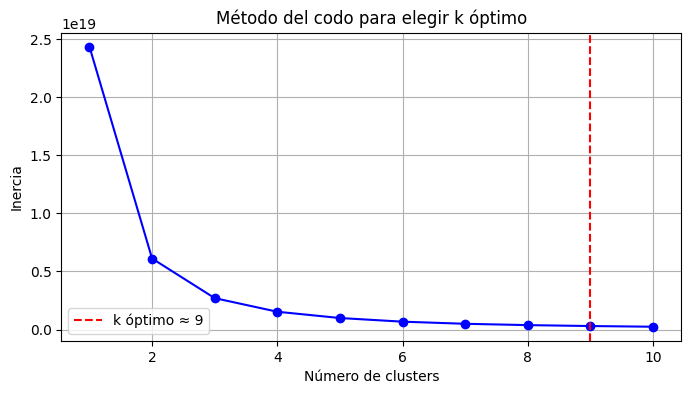

In [87]:
inertias = []
k_values = range(1, 11)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

# Encontrar el punto de mayor cambio de pendiente (heurístico)
deltas = np.diff(inertias)
delta_ratios = np.diff(deltas)
k_opt = np.argmin(delta_ratios) + 2  # +2 por los dos np.diff consecutivos

plt.figure(figsize=(8, 4))
plt.plot(k_values, inertias, 'bo-')
plt.axvline(x=k_opt, color='red', linestyle='--', label=f'k óptimo ≈ {k_opt}')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo para elegir k óptimo')
plt.legend()
plt.grid(True)
plt.show()

***6. Evaluar con Coeficiente de Silhouette***

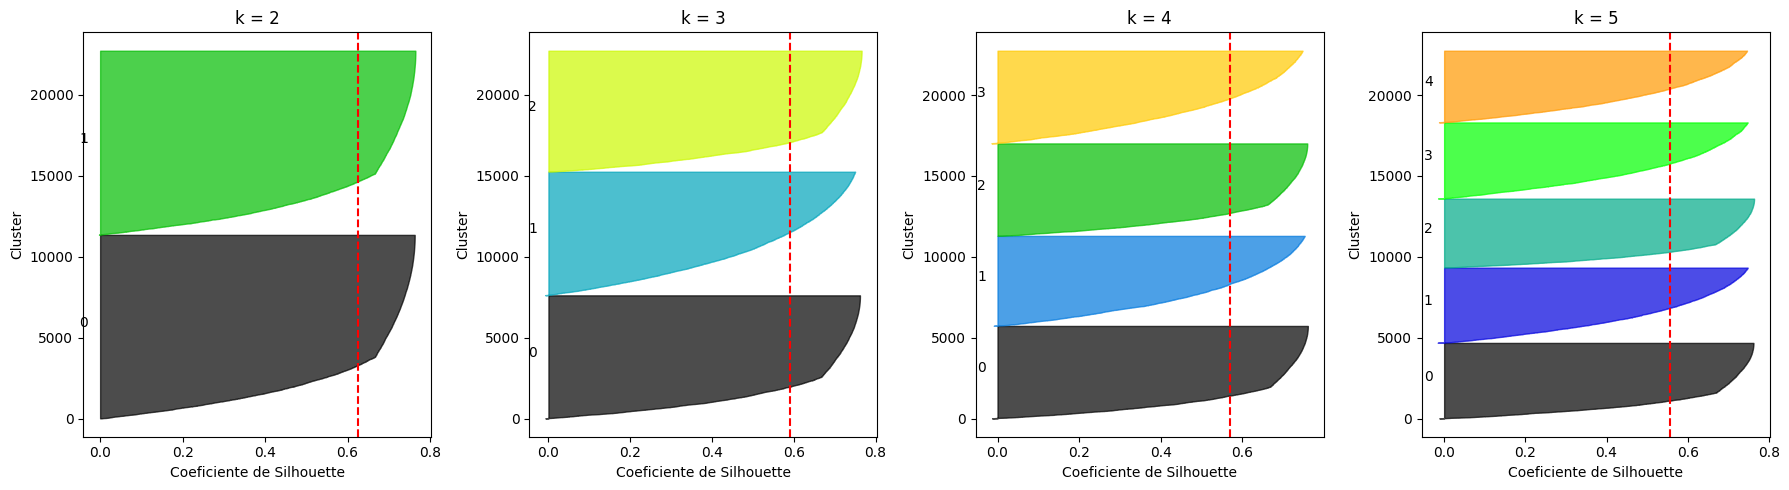

In [88]:
from matplotlib import cm

k_range = range(2, 6)
fig, axes = plt.subplots(1, len(k_range), figsize=(18, 5))

for idx, k in enumerate(k_range):
    ax = axes[idx]
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_vals = silhouette_samples(X, labels)
    y_lower = 10
    for i in range(k):
        cluster_vals = silhouette_vals[labels == i]
        cluster_vals.sort()
        size_cluster = cluster_vals.shape[0]
        y_upper = y_lower + size_cluster
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
        y_lower = y_upper + 10
    score = silhouette_score(X, labels)
    ax.axvline(x=score, color="red", linestyle="--")
    ax.set_title(f"k = {k}")
    ax.set_xlabel("Coeficiente de Silhouette")
    ax.set_ylabel("Cluster")

plt.tight_layout()
plt.show()


***6.1 Evaluar con Gráfico de Silhouette Global***

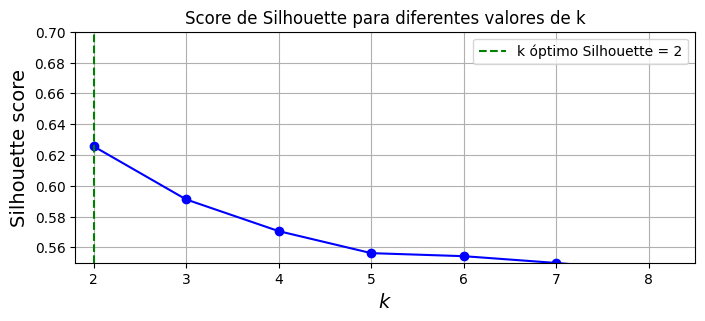

In [89]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
k_opt_silhouette = np.argmax(silhouette_scores) + 2  # +2 porque empezamos en k=2

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.axvline(x=k_opt_silhouette, color='green', linestyle='--', label=f'k óptimo Silhouette = {k_opt_silhouette}')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.title("Score de Silhouette para diferentes valores de k")
plt.legend()
plt.grid(True)
plt.show()

*** Aplicar K-Means Clustering***

In [90]:
k = k_opt_silhouette  # Usar el valor óptimo basado en silhouette k_opt_silhouette  o utilizar k_opt_codo
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)




*** Visualizar Clusters Resultantes***

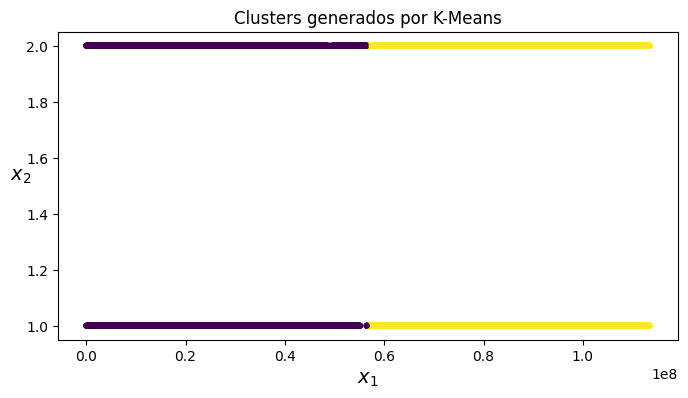

In [91]:
plt.figure(figsize=(8, 4))
plot_clusters(X, y_pred)
plt.title("Clusters generados por K-Means")
plt.show()

*** Ver Centros de los Clusters***

In [92]:
kmeans.cluster_centers_

array([[2.83426444e+07, 1.55341522e+00],
       [8.50120516e+07, 1.55904059e+00]])

*** Funciones para Visualizar Fronteras de Decisión***

In [93]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, circle_color='w', cross_color='k'):
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=10, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=10,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap="Pastel2")
    plt.contour(xx, yy, Z, linewidths=1, colors='k')
    plot_data(X)
    plot_centroids(clusterer.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

*** Visualizar Fronteras de los Clusters***

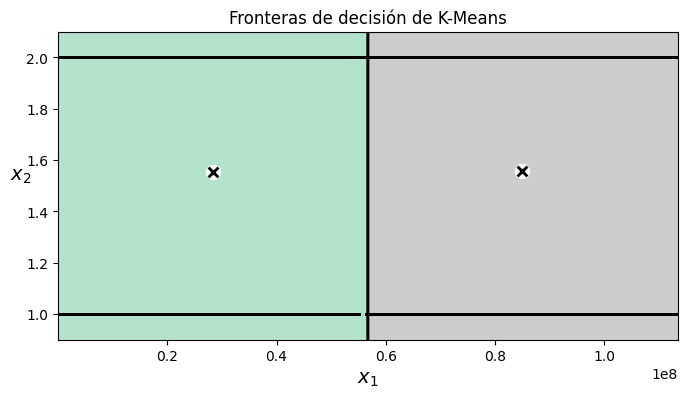

In [94]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.title("Fronteras de decisión de K-Means")
plt.show()